## Intel Image Classification

Image Classification is one of the basic tasks that a CNN can do. In this project I will be implementing CNN classification on an Intel Image Classification dataset, which contains around 25,000 (of which I shall use 3000) images of size 150x150 pixels, distributed under 6 categories (buildings, forests, glaciers, mountains, seas, and streets) of natural scenery around the world.  

This technology can be used for educational purposes - it provides a good understanding on how to create the network architecture for a CNN model.  In real-world applications this technology has a vast scope - it can be used to classify satellite images,  drone images, and classify search engine images to their respective categories. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

I will visualise some of the mountain images that I will be working with, it also helps to observe x and y dimensions. 

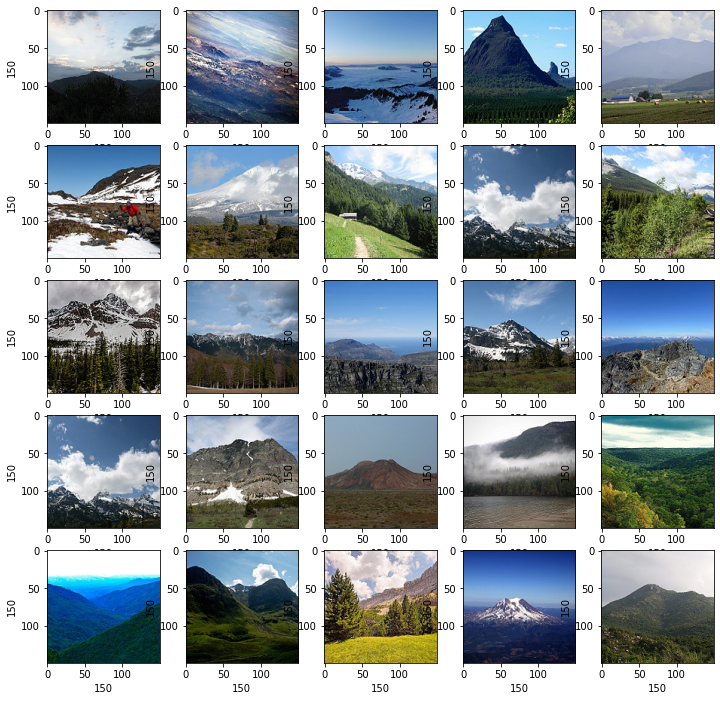

In [2]:
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/ML Projects/IntelClassificationData/mountain"
for i in range(1,26):
  plt.subplot(5,5,i)
  rand_img = imread(path + "/" + random.choice(sorted(listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize=10)
  plt.ylabel(rand_img.shape[0], fontsize=10)

I will now set the root directory for the dataset and create 2 empty lists for the images and labels. 

In [3]:
dir = "/content/drive/MyDrive/ML Projects/IntelClassificationData"
root_dir = listdir(dir)
image_list, label_list = [], []

Next I will resize all the images as some of them don't have the same dimensions.  The images will be then converted into an array and append the lists created above with the image and it's label. 

In [4]:
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # not all images have the same dimensions
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

Checking the count of images per class. 

In [5]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64

I can see there are a different amounts of images within each class,  but they are between 130-40 so no real imbalance.  

Next, I will store the number of classes as I will be using it later in the model architecture.

In [6]:
num_classes = len(label_counts)
num_classes

6

I will now check the shape of the x data, the input layer, for the model architecture

In [7]:
np.array(image_list).shape

(3000, 150, 150, 3)

To cross reference I will check the y data shape

In [8]:
label_list = np.array(label_list)
label_list.shape

(3000,)

Both are equal - I will split the data into test and train. 

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 42)

Normalising the images by dividing them with 255 and reshapring the x_train and x_test data. 

In [10]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape(-1, 150,150,3)
x_test = x_test.reshape(-1, 150,150,3)

Next, I will use a label binarizer; one hot encode to the y data.

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Split the traning data into train and validation

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

It's time to build the CNN architecture for the model. I will use different types of layers according to their features:

**Conv_2d:** is used to create a Convolutional Kernel that is colnvolved with the input layer to produce the output tensor.

**Max_pooling2d:** is a downsampling technique which takes out the maximum value over the window defined by the poolsize.

**Flatten:** flattens the input and creates a 1D output.

**Dense:** the dense layer produce the output as the dot product of input and kernel.

In [13]:
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 146, 146, 32)      0

306k params are trainable, with 0 non-trainable params.

Trainable parameters are those which value is adjusted/modified during training as per their gradient.

Non trainable parameters are those which value is not optimized during the training as per their gradient.

I can now compile the model. I have set the type of loss as a binary crossentropy as well as set the optimiser and metric.

In [14]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(0.0005), metrics=["accuracy"])

And now to train the model on the training datasets. 

In [15]:
epochs = 100
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/100
15/15 [==============================] - 23s 363ms/step - loss: 1.5699 - accuracy: 0.4172 - val_loss: 1.7677 - val_accuracy: 0.2250
Epoch 2/100
15/15 [==============================] - 4s 258ms/step - loss: 1.2133 - accuracy: 0.5411 - val_loss: 1.8169 - val_accuracy: 0.1875
Epoch 3/100
15/15 [==============================] - 4s 268ms/step - loss: 1.0335 - accuracy: 0.6292 - val_loss: 1.9071 - val_accuracy: 0.2042
Epoch 4/100
15/15 [==============================] - 4s 249ms/step - loss: 0.9304 - accuracy: 0.6938 - val_loss: 2.0191 - val_accuracy: 0.1562
Epoch 5/100
15/15 [==============================] - 4s 272ms/step - loss: 0.8800 - accuracy: 0.7104 - val_loss: 2.1049 - val_accuracy: 0.1979
Epoch 6/100
15/15 [==============================] - 4s 249ms/step - loss: 0.7809 - accuracy: 0.7646 - val_loss: 2.1771 - val_accuracy: 0.1604
Epoch 7/100
15/15 [==============================] - 4s 250ms/step - loss: 0.7077 - accuracy: 0.7760 - val_loss: 2.2966 - val_accuracy: 0.156

I will now save this model and use it for later predictions. 

In [16]:
model.save("/content/drive/MyDrive/ML Projects/IntelClassificationData/intel_model.h5")

I will now plot the accuracy of the model for the training history. 

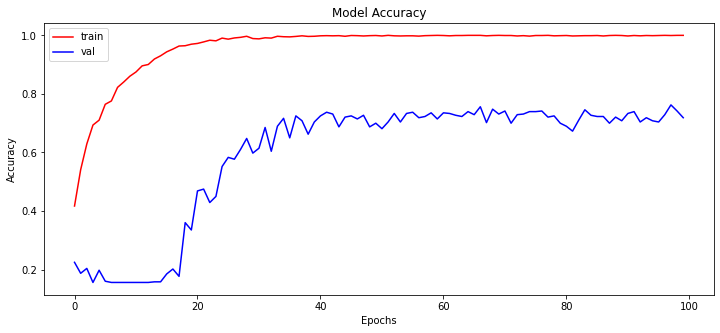

In [17]:
plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="b")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

The model is showing some overfitting - in order to reduce this I can lower the epochs, use dropouts etc. 

Now,  I will plot the loss history. 



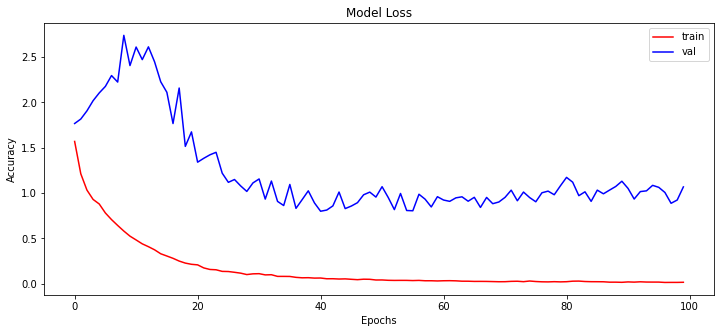

In [18]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="b")
plt.title("Model Loss")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

Next, I will check the accuracy on the test data. 

In [20]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 [==============================] - 1s 42ms/step - loss: 1.0639 - accuracy: 0.7183
Test Accuracy: 71.83333039283752


Now I will generate some prediction son the test data and store them in y_pred.

In [21]:
y_pred = model.predict(x_test)

I will pull an image and use it for predition.

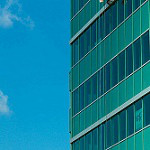

In [22]:
img = array_to_img(x_test[1])
img

Now I will have the model predict the image. 

In [26]:
labels = lb.classes_
print(labels)
print("Original Image: ", labels[np.argmax(y_test[1])])
print("Prediction: ", labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Original Image:  buildings
Prediction:  glacier


As you can see the model has incorrectly predicted a picture of the buildings as a glacier, which is incorrect.  

My first approach at tuning this model would be to reduce the epochs and change the dropout layers to 0.5. 